In [211]:
# ideas
# vlt auch nochmal die dublicates im allgemeinen raushauen oder startifien 
# check wie viele duplicates im oder außerhalb vom split sind
# mass als baseline benutzen, dann nehme ich alle und mache feature im portance gehe nur mit mass und charge weiter dann mache ich randomized cross validation und zeige wie sich die features angepasst haben
# min max nach dem splitten 



# load and show dataset
import pandas as pd

file_path = 'RandomForest Datenset 1.csv'
data = pd.read_csv(file_path, sep = "\t").dropna()
print(data['Charge'].value_counts())

data

Charge
2    78454
1    35452
3    26913
4     3294
Name: count, dtype: int64


,Sequence,Charge,Mass,Length,CCS,NumRotatableBonds,NumConformers,NumAtoms,FractionSP3
0,AAAAAAAAAAAATGTEAGPGTAGGSENGSEVAAQPAGLSGPAEVGPGAVGER,4,4401.106890,52,2.654046e-35,134.0,0.0,309.0,0.668508
1,AAAAAAAAAK,1,785.439552,10,5.981752e-36,23.0,0.0,55.0,0.696970
2,AAAAAAAAAPAAAATAPTTAATTAATAAQ,2,2367.203020,29,1.208337e-35,64.0,0.0,166.0,0.696970
3,AAAAAAAAAPAAAATAPTTAATTAATAAQ,3,2367.203020,29,2.200959e-35,64.0,0.0,166.0,0.696970
4,AAAAAAAK,1,643.365324,8,6.811654e-36,19.0,0.0,45.0,0.703704
...,...,...,...,...,...,...,...,...,...
144112,YYYNCRTEVSQWEK,3,1924.841400,14,2.846427e-35,58.0,0.0,132.0,0.464286
144113,YYYNCRTEVSQWEKPK,3,2149.989120,16,2.854486e-35,65.0,0.0,148.0,0.505263
144114,YYYQGCASWK,2,1324.554660,10,1.742139e-35,36.0,0.0,90.0,0.383333
144115,YYYVCQYCPAMKTYLNK,3,2264.010450,17,2.726609e-35,64.0,0.0,150.0,0.510000


In [212]:
# Schritt 1: Nach Sequenzen gruppieren
grouped = data.groupby("Sequence")

# Erstellen einer Liste, in der jede Sequenz eine Gruppe ist
grouped_data = [(seq, group) for seq, group in grouped]

In [213]:

# splitting
from sklearn.model_selection import train_test_split

X_unscaled = data.drop(columns=['CCS', 'Sequence', 'NumConformers'])
y_unscaled = data['CCS']

# test mit duplicates 
# data_test = data

train_groups, test_groups = train_test_split(grouped_data, test_size = 0.2, random_state=42)

# Schritt 3: Die Gruppendaten wieder in DataFrames konvertieren
train_df = pd.concat([group for _, group in train_groups])
test_df = pd.concat([group for _, group in test_groups])
# train_df = train_groups
# test_df = test_groups

In [214]:
len(train_df)

115284

In [215]:
len(test_df)

28829

In [218]:
# Schritt 4: Sicherstellen, dass keine Sequenz in beiden Splits vorkommt
# Liste der Sequenzen in test_df
test_sequences = test_df['Sequence'].unique()

# Entfernen aller Zeilen aus train_df, deren Sequenz auch in test_df vorkommt
train_df = train_df[~train_df['Sequence'].isin(test_sequences)]

len(train_df)



115284

In [219]:
# preprocessing
from sklearn.preprocessing import MinMaxScaler
y_scaler = MinMaxScaler()
X_scaler = MinMaxScaler()

# scale train
y_train_unscaled = train_df['CCS'].values.reshape(-1,1) * 1e40
y_train = y_scaler.fit_transform(y_train_unscaled)
X_train_unscaled = train_df.drop(columns=['CCS', 'Sequence', 'NumConformers'])
X_train = pd.DataFrame(X_scaler.fit_transform(X_train_unscaled), columns=X_train_unscaled.columns)


In [220]:

# scale test 
y_test_unscaled = test_df['CCS'].values.reshape(-1,1) * 1e40
y_test = y_scaler.transform(y_test_unscaled)
X_test_unscaled = test_df.drop(columns=['CCS', 'Sequence', 'NumConformers'])
X_test = pd.DataFrame(X_scaler.transform(X_test_unscaled), columns=X_test_unscaled.columns)

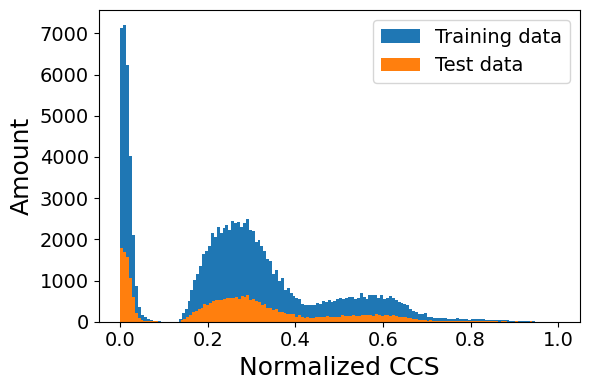

In [221]:

import matplotlib.pyplot as plt
plt.figure(figsize=(6, 4))
plt.hist(y_train, label="Training data", bins=150)
plt.hist(y_test, label= "Test data", bins=150)
#plt.title("Distribution of the splitted dataset", fontsize=18)
plt.ylabel("Amount",fontsize=18)
plt.xlabel("Normalized CCS", fontsize=18)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig("Normalized CCS.png", dpi=300)
plt.show()

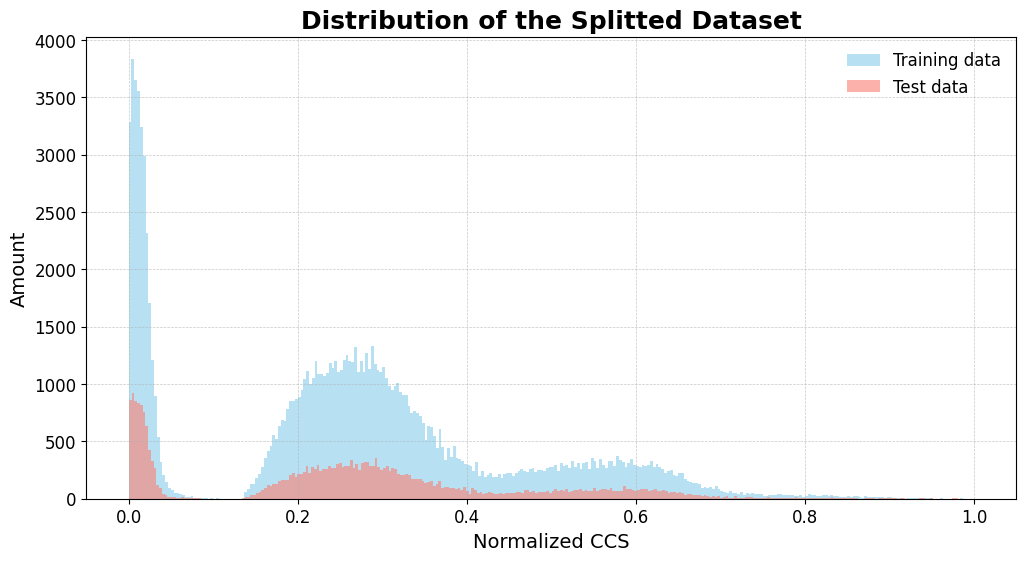

In [222]:
import matplotlib.pyplot as plt

# Set a larger figure size for readability
plt.figure(figsize=(12, 6))

# Increase the transparency (alpha) of the histograms and choose distinct colors for better visibility
plt.hist(y_train, label="Training data", bins=300, alpha=0.6, color='skyblue')
plt.hist(y_test, label="Test data", bins=300, alpha=0.6, color='salmon')

# Title and axis labels with larger font sizes
plt.title("Distribution of the Splitted Dataset", fontsize=18, weight='bold')
plt.xlabel("Normalized CCS", fontsize=14)
plt.ylabel("Amount", fontsize=14)

# Add a grid for easier readability
plt.grid(visible=True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

# Increase legend font size and position it outside the plot
plt.legend(fontsize=12, loc='upper right', frameon=False)

# Improve tick label readability
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Save and display the plot
plt.savefig("Normalized_CCS_Presentation.png", dpi=300, bbox_inches='tight')
plt.show()


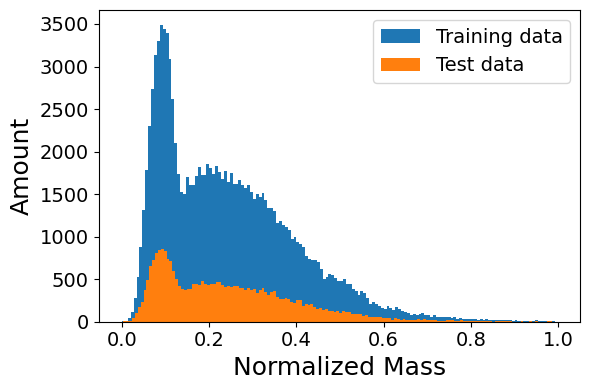

In [223]:
plt.figure(figsize=(6, 4))
plt.hist(X_train["Mass"], label="Training data", bins=150)
plt.hist(X_test["Mass"], label= "Test data", bins=150)
#plt.title("Distribution of the splitted dataset", fontsize=18)
plt.ylabel("Amount",fontsize=18)
plt.xlabel("Normalized Mass", fontsize=18)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig("Normalized Mass.png", dpi=300)
plt.show()

Mean Squared Error: 0.003579948426658627
Mean Absolute Error: 0.0441257642995971
R² Score: 0.9062588782910261


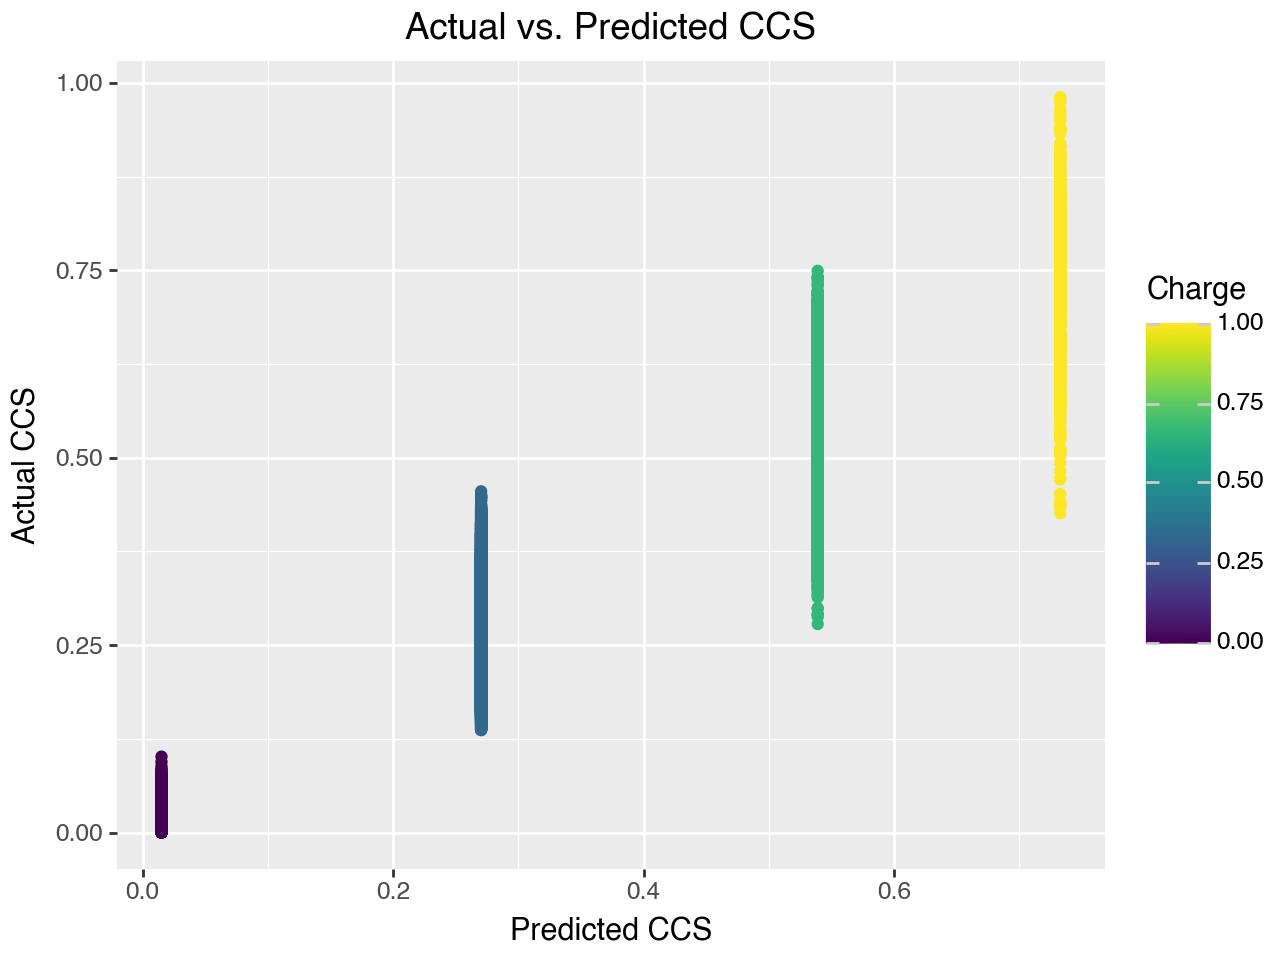

In [248]:
# Model for baseline prediction 
# train first model
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

cur_features = ['Charge']

modelBaseline = RandomForestRegressor(n_estimators=10, random_state=42)
modelBaseline.fit(X_train[cur_features], y_train.ravel())

# evaluate  model
y_pred = modelBaseline.predict(X_test[cur_features])
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R² Score: {r2}")
from matplotlib.pyplot import hist

from plotnine import ggplot, aes, geom_point, labs, scale_color_brewer, scale_color_distiller, scale_fill_gradient, theme, element_text

df= pd.DataFrame()
df['Charge'] = X_test['Charge']
df['CCS_pred'] = y_pred
df['CCS_actual'] = y_test
(
    ggplot(df, aes(x = "CCS_pred", y = "CCS_actual", color="Charge"))
    +  labs(y = "Actual CCS", x = "Predicted CCS", title="Actual vs. Predicted CCS")

    + geom_point() 
  
    
    # + scale_color_distiller(palette = "Blues")

)



Mean Squared Error: 0.00040582496803395166
Mean Absolute Error: 0.011666453054849573
R² Score: 0.9893734536962259


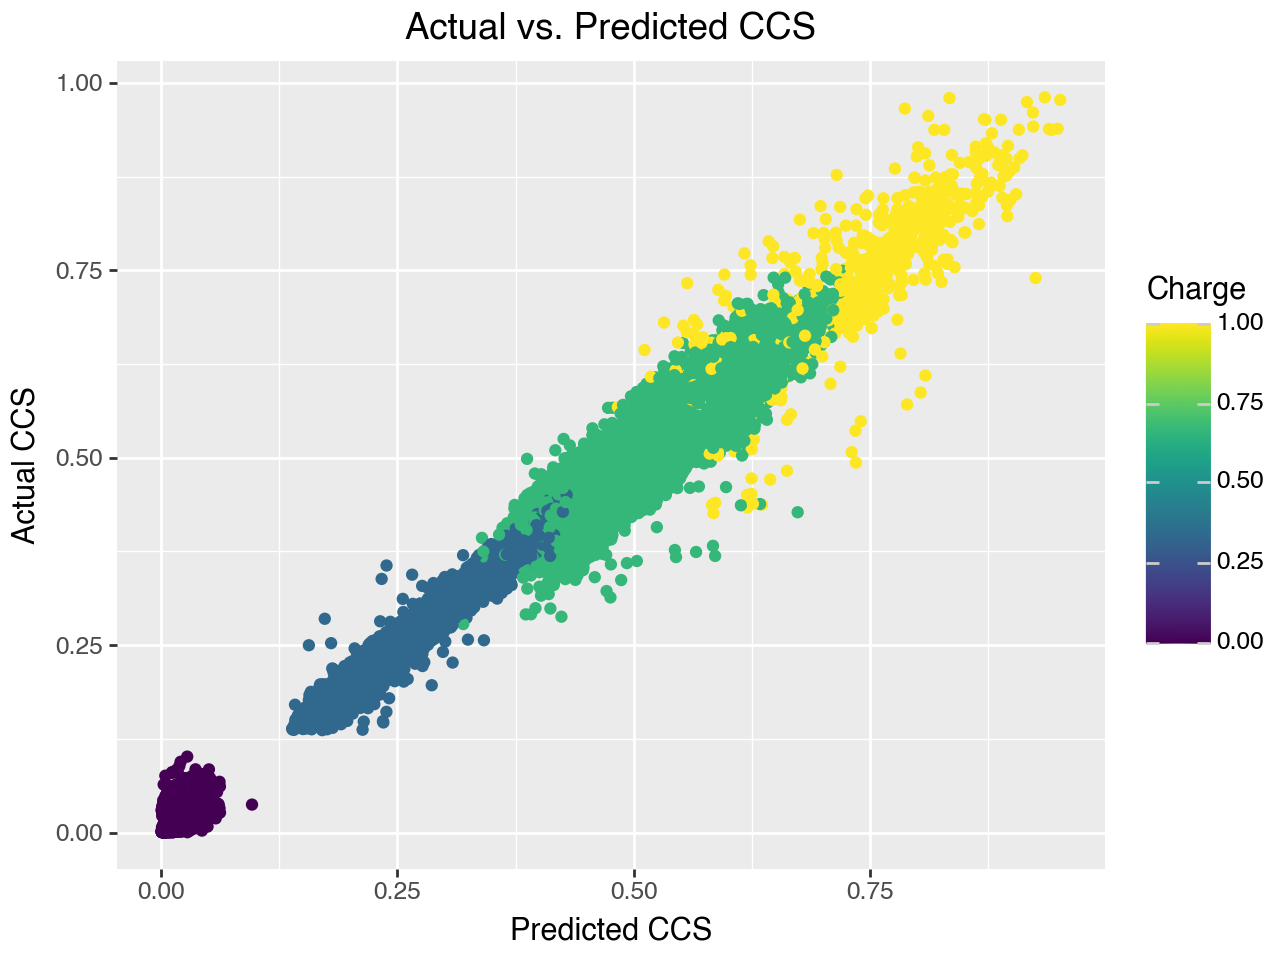

In [249]:
# Model with all relevant features
# ['Charge', 'Mass', 'Length', 'NumRotatableBonds', 'NumAtoms', 'FractionSP3']

cur_features = ['Charge', 'Mass', 'Length', 'NumRotatableBonds', 'NumAtoms', 'FractionSP3']

modelAll = RandomForestRegressor(n_estimators=10, random_state=42)
modelAll.fit(X_train[cur_features], y_train.ravel())

# evaluate model
y_pred = modelAll.predict(X_test[cur_features])
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R² Score: {r2}")
df= pd.DataFrame()
df['Charge'] = X_test['Charge']
df['CCS_pred'] = y_pred
df['CCS_actual'] = y_test
(
    ggplot(df, aes(x = "CCS_pred", y = "CCS_actual", color="Charge"))
    +  labs(y = "Actual CCS", x = "Predicted CCS", title="Actual vs. Predicted CCS")
    + geom_point() 
)

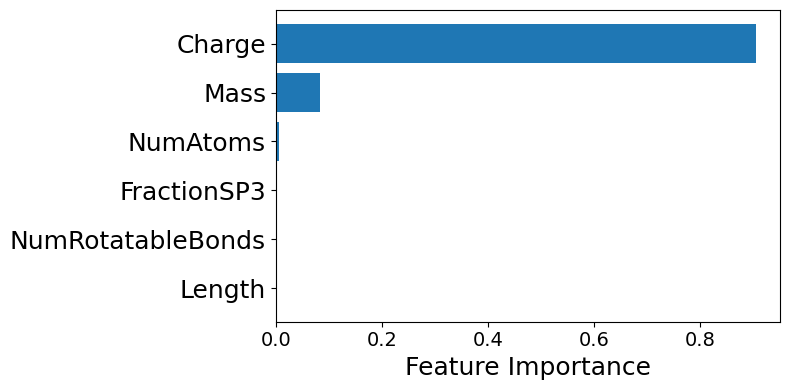

,feature,importance
0,Charge,0.905669
1,Mass,0.082958
4,NumAtoms,0.005987
5,FractionSP3,0.002822
3,NumRotatableBonds,0.001603
2,Length,0.000961


In [250]:

# Extract feature importances
importances = modelAll.feature_importances_
feature_names = ['Charge', 'Mass', 'Length', 'NumRotatableBonds', 'NumAtoms', 'FractionSP3']

# Sort the features by importance
feature_importances = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importances = feature_importances.sort_values(by='importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(8, 4))
plt.barh(feature_importances['feature'], feature_importances['importance'])
plt.xlabel('Feature Importance', fontsize=18)
#plt.title('Feature Importance from Random Forest')
plt.gca().invert_yaxis()  # Reverse order to have the most important at the top
plt.xticks(fontsize=14)
plt.yticks(fontsize=18)
plt.tight_layout()
plt.savefig("FeatureImportance.png", dpi=300)
plt.show()

feature_importances

Mean Squared Error: 0.00046839269992682113
Mean Absolute Error: 0.012177094999297004
R² Score: 0.9877351146277779


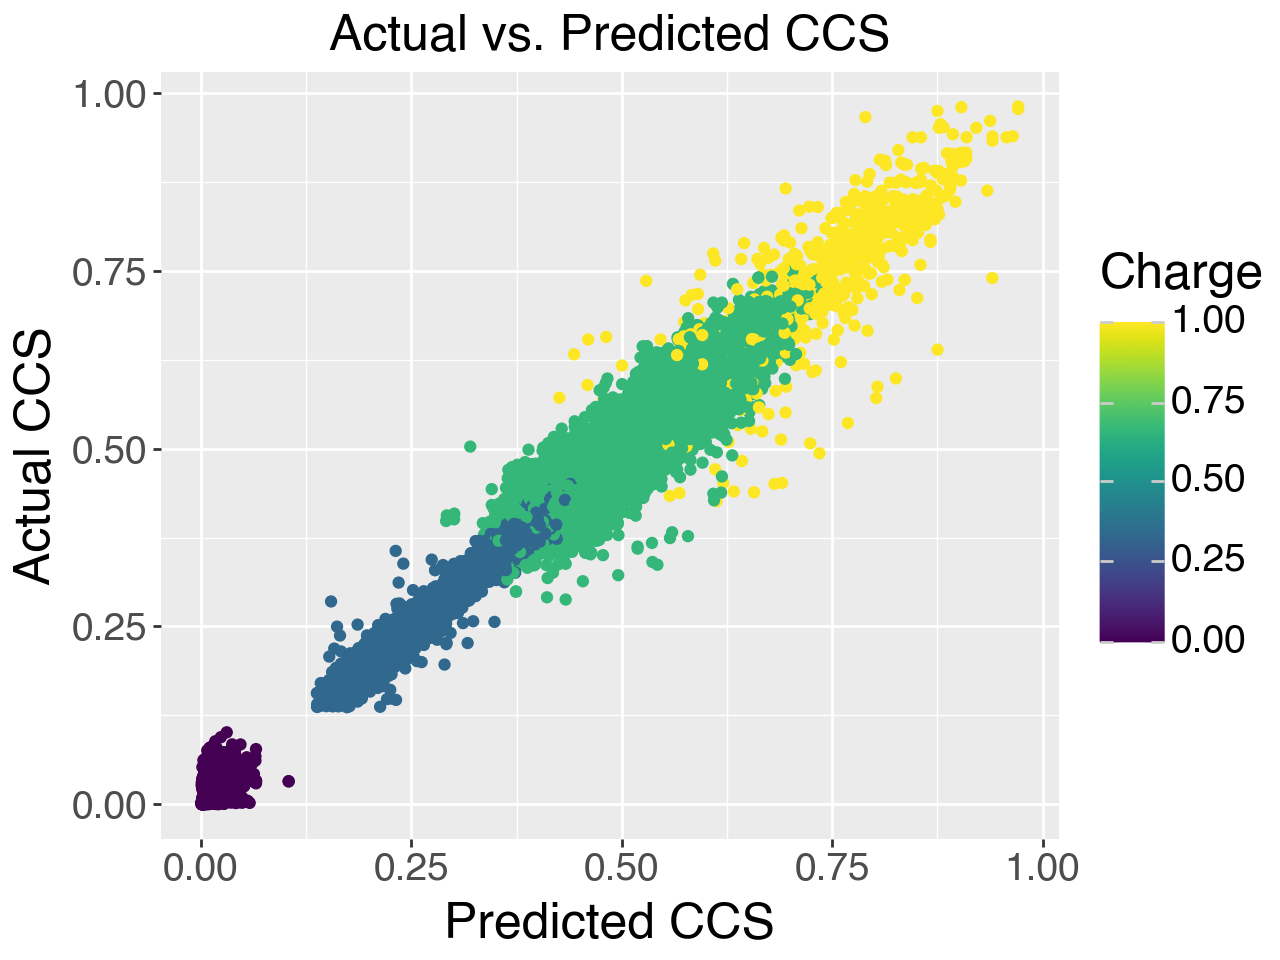

In [251]:
# Model with all relevant features
# ['Charge', 'Mass', 'Length', 'NumRotatableBonds', 'NumAtoms', 'FractionSP3']

cur_features = ['Charge', 'Mass']

model = RandomForestRegressor(n_estimators=10, random_state=42)
model.fit(X_train[cur_features], y_train.ravel())

# evaluate model
y_pred = model.predict(X_test[cur_features])
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R² Score: {r2}")

df= pd.DataFrame()
df['Charge'] = X_test['Charge']
df['CCS_pred'] = y_pred
df['CCS_actual'] = y_test
(
    ggplot(df, aes(x = "CCS_pred", y = "CCS_actual", color="Charge"))
    +  labs(y = "Actual CCS", x = "Predicted CCS", title="Actual vs. Predicted CCS")
    + geom_point() 
    + theme(
        plot_title=element_text(size=18),         # Schriftgröße des Titels
        axis_title_x=element_text(size=18),       # Schriftgröße der X-Achsenbeschriftung
        axis_title_y=element_text(size=18),       # Schriftgröße der Y-Achsenbeschriftung
        legend_title=element_text(size=18), 
        axis_text_x=element_text(size=14),        # X-axis tick label font size
        axis_text_y=element_text(size=14), # Schriftgröße des Legendentitels
        legend_text=element_text(size=14)         # Schriftgröße des Legendentextes
    )
)


array([0.22259723, 0.35376121, 0.3607451 , ..., 0.01321831, 0.18592646,
       0.18482003])

In [252]:
# hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'n_estimators': list(range(1,25)),
    'max_depth': list(range(1,30)),
    'min_samples_split': list(range(1,10)),
    'max_features': list(range(1,10)),
    'min_samples_leaf': list(range(1,15))
}


random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=10, cv=5, random_state=42)
random_search.fit(X_train, y_train.ravel())

print("Beste Parameter:", random_search.best_params_)


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
5 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packag

Beste Parameter: {'n_estimators': 20, 'min_samples_split': 2, 'min_samples_leaf': 14, 'max_features': 6, 'max_depth': 25}


In [253]:
# evaluate optimized model

# Output results from cross-validation
best_model = random_search.best_estimator_
scores = cross_val_score(best_model, X_train, y_train.ravel(), cv=5, scoring='r2')
print("Cross-validation scores for each fold:", scores)
print("Mean cross-validation score:", scores.mean())

# Output results from testing
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R² Score: {r2}")




Cross-validation scores for each fold: [0.99013719 0.99053942 0.99047561 0.99062577 0.99097546]
Mean cross-validation score: 0.9905506898206111
Mean Squared Error: 0.0003615721950681037
Mean Absolute Error: 0.010903347894061218
R² Score: 0.9905322146844179


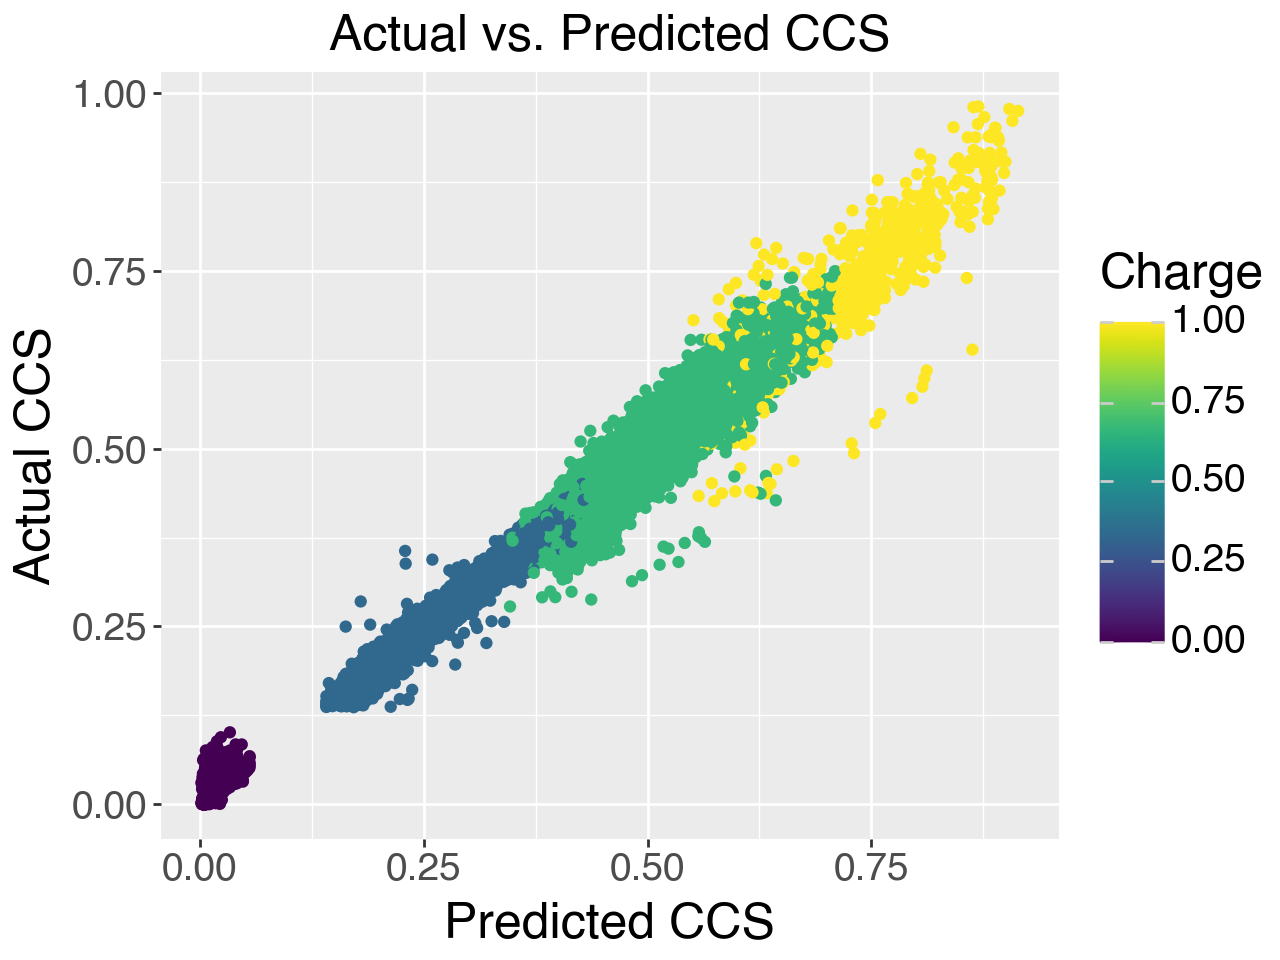

In [254]:

from plotnine import ggplot, aes, geom_point, labs, scale_color_brewer, scale_color_distiller, scale_fill_gradient, theme, element_text

df= pd.DataFrame()
df['Charge'] = X_test['Charge']
df['CCS_pred'] = y_pred
df['CCS_actual'] = y_test
(
    ggplot(df, aes(x = "CCS_pred", y = "CCS_actual", color="Charge"))
    +  labs(y = "Actual CCS", x = "Predicted CCS", title="Actual vs. Predicted CCS")
    + geom_point() 
    + theme(
        plot_title=element_text(size=18),         # Schriftgröße des Titels
        axis_title_x=element_text(size=18),       # Schriftgröße der X-Achsenbeschriftung
        axis_title_y=element_text(size=18),       # Schriftgröße der Y-Achsenbeschriftung
        legend_title=element_text(size=18), 
        axis_text_x=element_text(size=14),        # X-axis tick label font size
        axis_text_y=element_text(size=14), # Schriftgröße des Legendentitels
        legend_text=element_text(size=14)         # Schriftgröße des Legendentextes
    )
)


In [ ]:
from sklearn.model_selection import LearningCurveDisplay

LearningCurveDisplay.from_estimator(
   estimator=best_model, X=X_train, y=y_train.ravel(), train_sizes=[10,100,1000,10000,50000], cv=5, scoring='r2', verbose=2, random_state=42)

In [ ]:
from sklearn.model_selection import ValidationCurveDisplay

#'neg_mean_squared_error'

ValidationCurveDisplay.from_estimator(
   best_model, X_train, y_train.ravel(), param_name="n_estimators", param_range=list(range(1,25)), scoring='r2', verbose=2)

In [ ]:

# # plotting
# from plotnine import ggplot, aes, geom_point, coord_equal
# 
# # Plot
# df = pd.DataFrame({
#     'Predicted': y_pred.ravel(),
#     'Actual': y_test.ravel()
# })
# 
# (
#     ggplot(df, aes("Predicted", "Actual"))
#     + geom_point()
#    
# )


In [ ]:
# max(max(df['CCS_pred']), max(df['CCS_actual']))

In [ ]:
# from plotnine import scale_x_continuous, scale_y_continuous
# 
# for charge in range(1,4):
#     df_temp = df[df['Charge'] == charge]
#     x_limit_max = max(max(df_temp['CCS_pred']), max(df_temp['CCS_actual']))
#     x_limit_min = min(min(df_temp['CCS_pred']), min(df_temp['CCS_actual']))
#    
#     plot = (
#     ggplot(df_temp, aes(x = "CCS_pred", y = "CCS_actual"))
#     + geom_point()
#     + scale_x_continuous(limits=(x_limit_min,x_limit_max))
#     + scale_y_continuous(limits=(x_limit_min,x_limit_max))
# 
#     )
#     
#     plot.show()
    

In [ ]:
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.preprocessing import QuantileTransformer
# from sklearn.preprocessing import MaxAbsScaler
# 
# scaler = MaxAbsScaler()
# y = data['CCS'].values.reshape(-1,1) *1e40
# y_scaled = scaler.fit_transform(y)

# import matplotlib.pyplot as plt
# 
# plt.hist(y)
# plt.title('Unscaled')
# plt.show()
# 
# plt.hist(y_scaled)
# plt.title("Scaled")
# plt.show()
# min_y = min(y)
# max_y = max(y)
# 
# print(min_y, max_y)
# 
# y_scaled = (y-min_y) / ( max_y-min_y )
# 
# plt.hist(y_scaled, bins=500)
# plt.title("Scaled")
# plt.show()
#X = data.drop(columns=['CCS', 'Sequence', 'NumConformers'])

# X = pd.DataFrame(data[['Mass']])
# charge = 4
# X = data[data['Charge'] == charge].drop(columns=['Charge', 'CCS', 'Sequence', 'NumConformers'])
# y = y[data['Charge'] == charge]
# X



# from sklearn.model_selection import GridSearchCV
# 
# # Define the parameter grid
# param_grid = {
#     'n_estimators': [2],  # Number of trees in the forest
#     'max_depth': [None, 10, 20, 30],    # Maximum depth of the tree
#     'min_samples_split': [2, 5, 10],    # Minimum samples required to split an internal node
#     'min_samples_leaf': [1, 2, 4]   ,     # Minimum samples required to be at a leaf node
#     'max_features': [2,3,5]
# }
# 
# # Initialize GridSearchCV
# grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='r2', verbose=2, n_jobs=-1)
# 
# # Fit GridSearchCV
# grid_search.fit(X, y.ravel())
# 
# # Output the best parameters and the best score
# print("Best Parameters:", grid_search.best_params_)
# print("Best Cross-Validation Score:", grid_search.best_score_)
# 
# # Perform cross-validation with the best estimator
# best_model = grid_search.best_estimator_
# scores = cross_val_score(best_model, X, y.ravel(), cv=5, scoring='r2')
# 
# # Output results from cross-validation
# print("Cross-validation scores for each fold:", scores)
# print("Mean cross-validation score:", scores.mean())
# 
# plt.show()


# from sklearn.ensemble import RandomForestRegressor
# from sklearn.model_selection import cross_val_score
# 
# model = RandomForestRegressor(n_estimators=10, random_state=42)
# 
# # Perform 5-fold cross-validation
# scores = cross_val_score(model, X, y.ravel(), cv=5, scoring='r2')
# 
# # Output results
# print("Cross-validation scores for each fold:", scores)
# print("Mean cross-validation score:", scores.mean())